In [43]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import os, shutil, pathlib
from PIL import Image

In [38]:
def make_graphs(obj):
    epochs = len(obj.history['loss'])
    fig, axes = plt.subplots(2, 1, figsize=(10, 8)) 
    make_graphs_loss(obj, epochs, axes[0]) 
    make_graphs_accuracy(obj, epochs, axes[1])  
    plt.tight_layout()

def make_graphs_loss(obj, epochs, ax):
    # makes graph from object and epochs
    eps = [i for i in range(epochs)]
    train_acc = obj.history['loss']
    val_acc = obj.history['val_loss']
    # Now make plot
    sns.lineplot(x=eps[1:], y=train_acc[1:], color='b', label='Training Loss', ax=ax)
    sns.lineplot(x=eps[1:], y=val_acc[1:], color='r', label='Validation Loss', ax=ax)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training vs Validation')
    ax.legend()

def make_graphs_accuracy(obj, epochs, ax):
    # makes graph from object and epochs
    eps = [i for i in range(epochs)]
    train_acc = obj.history['accuracy']
    val_acc = obj.history['val_accuracy']
    # Now make plot
    sns.lineplot(x=eps[1:], y=train_acc[1:], color='b', label='Training Accuracy', ax=ax)
    sns.lineplot(x=eps[1:], y=val_acc[1:], color='r', label='Validation Accuracy', ax=ax)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training vs Validation')
    ax.legend()


    

In [45]:
original_dir = r'images_sorted_tvts'
new_base_dir = r'images_sorted_tvts'

categories = ['american_bulldog','american_pit_bull_terrier',
             'basset_hound', 'beagle', 'boxer',
             'chihuahua','english_cocker_spaniel',
             'english_setter', 'german_shorthaired', 'great_pyrenees',
             'havanese', 'japanese_chin', 'keeshond', 'leonberger',
             'miniature_pinscher', 'newfoundland','pomeranian',
             'pug', 'saint_bernard', 'samoyed', 'scottish_terrier',
             'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier',
             'yorkshire_terrier', 'abyssinian', 'bengal', 'birman',
             'bombay', 'british_shorthair', 'egyptian_mau',
             'maine_coon', 'persian', 'ragdoll',
             'russian_blue', 'siamese', 'sphynx']

# Quickly convert from jpg
def convert_jpg_to_jpeg(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            jpg_path = os.path.join(directory, filename)
            jpeg_path = os.path.join(directory, os.path.splitext(filename)[0] + ".jpeg")
            try:
                with Image.open(jpg_path) as img:
                    # remove ICC profile from an image
                    if 'icc_profile' in img.info:
                        del img.info['icc_profile']
                    img.save(jpeg_path, "JPEG")
                os.remove(jpg_path)
                #print(f"Converted {jpg_path} to {png_path}")
            except Exception as e:
                print(f"Failed to convert {jpg_path}: {str(e)}")

                # move failed files to a folder to move somewhere else
                remove_folder = os.path.join(directory, "_remove")
                if not os.path.exists(remove_folder):
                    os.makedirs(remove_folder)
                try:
                    shutil.move(jpg_path, remove_folder)
                except Exception as move_error:
                    print(f"Failed to move {jpg_path} to {remove_folder}: {str(move_error)}")

for j in ["train", "test", "validation"]:
    for i in categories:
        category_dir = os.path.join(original_dir, j, i)
        convert_jpg_to_jpeg(category_dir)


# Make subset adapted from HW5.ipynb, 60-20-20??
def make_subset(subset_name, start_index, end_index):
    for category in categories:
        try:
            dir = os.path.join(new_base_dir, subset_name, category) #  ...\images_soretd_tvts\train\abyssinian.....
            os.makedirs(dir) # makes it
            fnames = [f"{category}_{i}.png" for i in range(start_index, end_index)]
            print(fnames)
            for fname in fnames:
                src_path = os.path.join(original_dir, category, fname)
                dst_path = os.path.join(dir, fname)
                shutil.copyfile(src=src_path, dst=dst_path)
        except IndexError:
            continue
        except:
            print(dir, " already created")

# make_subset('test', 0, 40)
# make_subset('validation', 40, 80)
# make_subset('train', 80, 200)

In [47]:
# search for _remove folders
for j in ["train", "test", "validation"]:
    for i in categories:
        category_dir = os.path.join(original_dir, j, i)
        remove_folder = os.path.join(category_dir, "_remove")
        if os.path.exists(remove_folder):
            print(f"Found _remove folder in {category_dir}")

In [35]:
#make_subset('train', 80, 200)

In [48]:
train_dataset = image_dataset_from_directory(
    r'images_sorted_tvts/train',
    image_size=(255, 255),
    batch_size=32,
    labels='inferred',
    label_mode='categorical')

val_data = image_dataset_from_directory(r'images_sorted_tvts/validation',
    image_size=(255, 255),
    batch_size=32,
    labels='inferred',
    label_mode='categorical')

Found 4420 files belonging to 37 classes.
Found 1478 files belonging to 37 classes.


In [49]:
VGG16_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
VGG16_base.trainable = False

inputs = keras.Input(shape=(255, 255, 3))
x = inputs
x = keras.applications.vgg16.preprocess_input(x)  # scale the data
x = VGG16_base(x)
x = layers.Flatten()(x)
x = layers.Dense(64)(x)   # only the weights in the dense layers will be trained
outputs = layers.Dense(37, activation="softmax")(x)     # only the weights in the dense layers will be trained
VGG16_Model = keras.Model(inputs, outputs)
VGG16_Model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [50]:
VGG16_hist = VGG16_Model.fit(train_dataset, epochs=5, validation_data= val_data)

Epoch 1/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step - accuracy: 0.3320 - loss: 4.6048 - val_accuracy: 0.5744 - val_loss: 1.9800
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.8571 - loss: 0.6833 - val_accuracy: 0.7057 - val_loss: 1.8000
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9204 - loss: 0.5331 - val_accuracy: 0.7179 - val_loss: 1.8800
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.9697 - loss: 0.3220 - val_accuracy: 0.7788 - val_loss: 1.6710
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9837 - loss: 0.2301 - val_accuracy: 0.7788 - val_loss: 1.7370


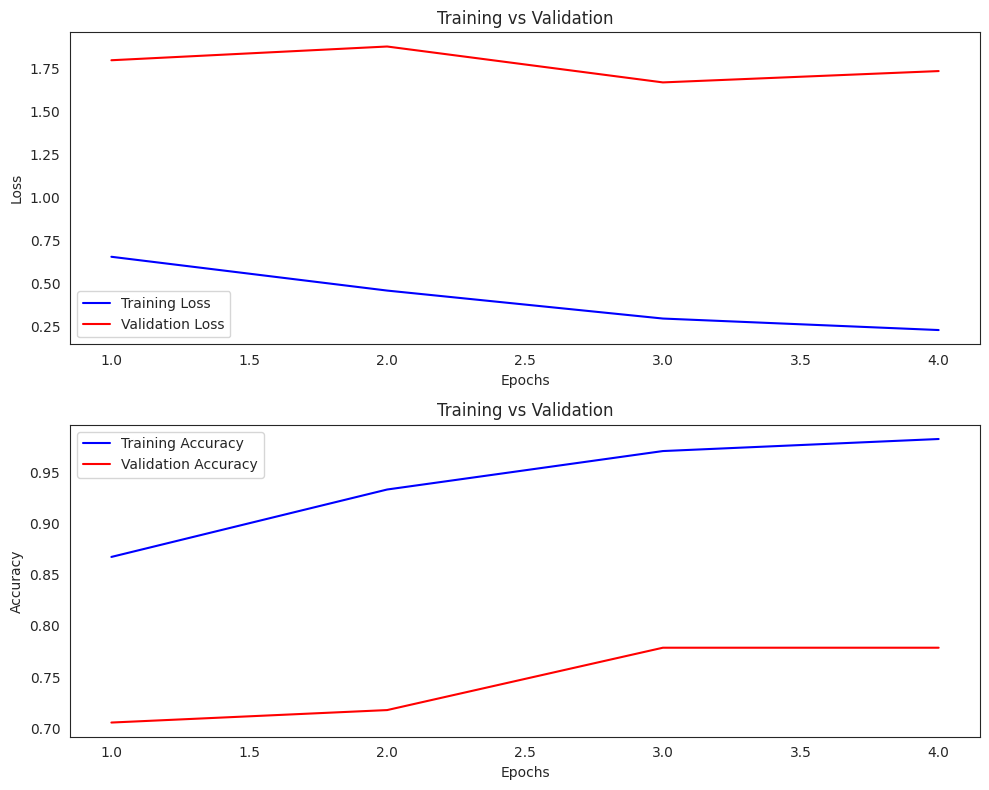

In [51]:
make_graphs(VGG16_hist)